<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/ob_flan_t5_sentiment_jpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
===================================================
Author: Oscar Bowden
Role: Research Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://uk.linkedin.com/in/oscar-bowden-4b14711b7
Date: 2025-02-24
Version: 2.1

Description:
    This notebook contains a fine-tuning pipeline for Flan-T5 (base) polar sentiment analysis.
    The data analysed is pre-processed financial meeting transcript
    data from JPMorganChase. Financial Phrasebank
    (https://huggingface.co/datasets/takala/financial_phrasebank) dataset is used for
    fine tuning. Tuned model performance is assessed alongside a zero-shot approach.
===================================================
"""

# Imports

In [ ]:
!pip install bertopic umap-learn datsets transformers torch evaluate scikit-learn > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
#Imports

from google.colab import drive
import os

import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import tensorflow as tf
import numpy as np
import random
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import gc
from transformers import DataCollatorForSeq2Seq

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import re

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data loading and pre-processing

* Here we will load and chunk both 'Question' and 'Answer' data, but for the purposes of model evaluation only the 'Question' data will be carried forward.

In [ ]:
# Load pre-processed (questions extracted via GPT) data

drive.mount('/content/drive', force_remount=True)

path = "/content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/jpmorgan_qna_df_preprocessed_final.csv"

df = pd.read_csv(path)

df.head()

Mounted at /content/drive


,Index,Quarter-Year,Question,Question_cleaned,Asked By,Role of the person asked the question,Answer,Answer_cleaned,Answered By,Role of the person answered the question
0,1,1Q23,"So, Jamie, I was actually hoping to get your p...",['so jamie actually hoping get perspective see...,Steven Chubak,"Analyst, Wolfe Research LLC","Well, I think you were already kind of complet...",['well think already kind complete answering q...,Jamie Dimon,"Chairman & Chief Executive Officer, JPMorgan C..."
1,2,1Q23,"Hey, thanks. Good morning. Hey, Jeremy, I was ...",['hey thanks good morning hey jeremy wondering...,Ken Usdin,"Analyst, Jefferies LLC","Yeah, sure. So let me just summarize the drive...",['yeah sure let summarize drivers change outlo...,Jeremy Barnum,"Chief Financial Officer, JPMorgan Chase & Co."
2,3,1Q23,"Hi, thanks. Jeremy, wanted to follow up again ...",['hi thanks jeremy wanted follow drivers nii r...,John McDonald,"Analyst, Autonomous Research","Yeah. John, it's a really good question, and w...",['yeah john really good question weve obviousl...,Jeremy Barnum,"Chief Financial Officer, JPMorgan Chase & Co."
3,4,1Q23,My first question is you mentioned that your r...,['first question mentioned reserve build drive...,Erika Najarian,"Analyst, UBS Securities LLC","Yeah. So, Erika, as you know, we take \n not g...",['yeah so erika know take going go lot detail ...,Jeremy Barnum,"Chief Financial Officer, JPMorgan Chase & Co."
4,5,1Q23,Hey. Good morning. Maybe just a little bit on ...,['hey good morning maybe little bit deposit th...,Jim Mitchell,"Analyst, Seaport Global Securities LLC","Yeah. A couple things there. So, first of all,...",['yeah couple things there so first all know r...,"Jeremy Barnum, Jamie Dimon","Chief Financial Officer, JPMorgan Chase & Co.;..."


In [ ]:
"""
# Summary table to show questions asked per analyst per quarter

# Group Data by Speaker and Quarter
speaker_question_counts = df.groupby(["Asked By", "Quarter-Year"]).size().reset_index(name="question_count")

# Pivot to Create a Summary Table
summary_df = speaker_question_counts.pivot(index="Asked By", columns="Quarter-Year", values="question_count").fillna(0)

summary_df
"""

* Now we will load the Financial PhraseBank dataset.
* https://huggingface.co/datasets/takala/financial_phrasebank
* Sentences_allagree version, which has 100% annotator agreement for every row.
* 8 annotators.
* Data is in the format: { "sentence": "Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .",
  "label": "negative"}
* Will need to prepare the quarterly question data in a similar way for the LLM to analyse sentiment.

In [ ]:
# Load the Financial PhraseBank Dataset (100% Annotator Agreement)
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree")

# Convert to Pandas DataFrame
df_fpb = pd.DataFrame(dataset["train"])

# Rename columns for consistency
df_fpb = df_fpb.rename(columns={"sentence": "text", "label": "sentiment"})  # Sentiment is already text

# Train-Test Split (80% Train, 20% Test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_fpb["text"], df_fpb["sentiment"], test_size=0.2, random_state=42
)

# Convert numeric labels to strings before creating Hugging Face datasets
train_labels = train_labels.astype(str)
test_labels = test_labels.astype(str)

# Convert to DataFrame for Hugging Face format
train_df = pd.DataFrame({"input_text": "Classify sentiment: " + train_texts, "output_text": train_labels})
test_df = pd.DataFrame({"input_text": "Classify sentiment: " + test_texts, "output_text": test_labels})

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df).remove_columns(["__index_level_0__"])
test_dataset = Dataset.from_pandas(test_df).remove_columns(["__index_level_0__"])

# To view
df_check = train_dataset.to_pandas()
print(df_check.shape)
df_check.head(5)

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for takala/financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/takala/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

(1811, 2)


,input_text,output_text
0,Classify sentiment: The robust growth was the ...,2
1,Classify sentiment: Operating profit fell to E...,0
2,Classify sentiment: Finnish electronics manufa...,0
3,Classify sentiment: Finland 's national carrie...,2
4,Classify sentiment: The Elcoteq group recently...,0


* Target variable is encoded and an instruction tag ("Classify sentiment:") is prepended to each sentence to prepare for later fine-tuning.
* 80/20 train/test split conducted.

In [ ]:
# Preparing 'Question' and 'Answer' columns of JPM data

# Create a new column that contains the list of sentences
df['Question_Sentences'] = df['Question'].apply(lambda x: sent_tokenize(str(x)))
df['Answer_Sentences'] = df['Answer'].apply(lambda x: sent_tokenize(str(x)))

# Explode the DataFrame
df_exploded_q2 = df.explode('Question_Sentences')
df_exploded_a2 = df.explode('Answer_Sentences')

# Rename columns
df_exploded_q2 = df_exploded_q2.rename(columns={'Question_Sentences': 'Question_Sentence'})
df_exploded_q2 = df_exploded_q2[['Question_Sentence', 'Question', 'Asked By', 'Quarter-Year']]

df_exploded_a2 = df_exploded_a2.rename(columns={'Answer_Sentences': 'Answer_Sentence'})
df_exploded_a2 = df_exploded_a2[['Answer_Sentence', 'Question', 'Asked By', 'Quarter-Year']]

print(df_exploded_q2.shape)
print(df_exploded_a2.shape)

#Remove rows with 3 or fewer words
df_exploded = df_exploded_q2[df_exploded_q2['Question_Sentence'].apply(lambda x: len(x.split()) > 3)]
df_exploded_a = df_exploded_a2[df_exploded_a2['Answer_Sentence'].apply(lambda x: len(x.split()) > 3)]

print(df_exploded.shape)
print(df_exploded_a.shape)

df_exploded.head()

(399, 4)
(1074, 4)
(342, 4)
(945, 4)


,Question_Sentence,Question,Asked By,Quarter-Year
0,"So, Jamie, I was actually hoping to get your p...","So, Jamie, I was actually hoping to get your p...",Steven Chubak,1Q23
0,In your letter you spent a fair amount of time...,"So, Jamie, I was actually hoping to get your p...",Steven Chubak,1Q23
0,But what are some of the changes that you're s...,"So, Jamie, I was actually hoping to get your p...",Steven Chubak,1Q23
0,"And along those same lines, how you're thinkin...","So, Jamie, I was actually hoping to get your p...",Steven Chubak,1Q23
1,"Hey, Jeremy, I was just wondering if you can j...","Hey, thanks. Good morning. Hey, Jeremy, I was ...",Ken Usdin,1Q23


* Q data in df_exploded
* A data in df_exploded_a
* Both datasets chunked by sentence, and we have removed rows with 3 or fewer words in the sentence.
* Metadata retained per sentence.

QUESTION DATA:
* 399 -> 342 rows. This was needed as many short irrelevant sentences such as "Thank you." or "Good morning." existed.

# 1) Flan-T5 sentiment extraction: zero-shot prompting

In [ ]:
# Setting environment variable to reduce GPU RAM fragmentation

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# Load Flan-T5 Model & Tokenizer
MODEL_NAME = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.eval()  # Set model to inference mode

# Define Optimized Sentiment Extraction Function
def extract_sentiment_flan_t5(text):
    """Uses Flan-T5 to classify sentiment as Positive, Negative, or Neutral."""

    # Updated Prompt with Examples for Clarity
    prompt = (
        f"Classify the sentiment of the following financial question as Positive, Negative, or Neutral.\n\n"
        f"Examples:\n"
        f"1. 'Will the company increase dividends this quarter?' → Positive\n"
        f"2. 'How will rising inflation impact profitability?' → Negative\n"
        f"3. 'What are your expectations for the next quarter?' → Neutral\n\n"
        f"Now classify this question:\n"
        f"Question: {text}\n\n"
        f"Sentiment:"
    )

    # Tokenize & Generate Response
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=5)  # Allow slightly longer responses

    sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # Ensure valid output
    valid_sentiments = {"Positive", "Negative", "Neutral"}
    return sentiment if sentiment in valid_sentiments else "Uncertain"  # Default to "Uncertain" instead of Neutral

# Apply Sentiment Extraction to Question Chunks
TEXT_COLUMN = "Question_Sentence"
df_exploded["flan_t5_sentiment_zero_shot"] = df_exploded[TEXT_COLUMN].dropna().apply(extract_sentiment_flan_t5)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# 2) Fine-tuning Flan-T5 with Financial Phrasebank

In [ ]:
# Load Flan-T5 Model & Tokenizer
MODEL_NAME = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

# Tokenization Function (Ensure Proper List Format)
def tokenize_function(examples):
    inputs = tokenizer(
        examples["input_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    targets = tokenizer(
        examples["output_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

    # Replace pad token ids with -100 for labels so that they are ignored in the loss computation
    labels = targets["input_ids"]
    labels = [[token if token != tokenizer.pad_token_id else -100 for token in label] for label in labels]

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }

# Apply tokenization correctly with proper batching
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print("✅ Tokenization successful!")

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

✅ Tokenization successful!


In [ ]:
"""
# Check data consistency - debugging

# Part 1: Check Data Consistency
def check_data_consistency(tokenized_dataset, tokenizer, num_samples=5):
    print(f"Checking data consistency for {num_samples} samples...\n")
    # Randomly choose sample indices
    indices = random.sample(range(len(tokenized_dataset)), num_samples)

    for idx in indices:
        example = tokenized_dataset[idx]
        input_ids = example["input_ids"]
        attention_mask = example["attention_mask"]
        labels = example["labels"]

        # Decode input text (skip special tokens for clarity)
        decoded_input = tokenizer.decode(input_ids, skip_special_tokens=True)

        # For labels, filter out -100 tokens (which are ignored by the loss function)
        filtered_labels = [token for token in labels if token != -100]
        decoded_labels = tokenizer.decode(filtered_labels, skip_special_tokens=True)

        print(f"Sample index: {idx}")
        print("Decoded Input: ", decoded_input)
        print("Decoded Labels:", decoded_labels)
        print("Input length:", len(input_ids))
        print("Attention mask sum (non-pad tokens):", sum(attention_mask))
        print("Labels length:", len(labels))
        print("Count of ignored (-100) tokens in labels:", labels.count(-100))
        print("-"*50)

# Run the consistency check on your tokenized training dataset
check_data_consistency(tokenized_train, tokenizer)

# Part 2: Debug a Single Forward Pass to Check Loss Computation
def debug_single_batch(tokenized_dataset, model, tokenizer, batch_size=4):
    # Take a small batch from the dataset
    sample_batch = tokenized_dataset.select(range(batch_size))

    # Convert lists to tensors and move to the same device as the model
    input_ids = torch.tensor(sample_batch["input_ids"]).to(model.device)
    attention_mask = torch.tensor(sample_batch["attention_mask"]).to(model.device)
    labels = torch.tensor(sample_batch["labels"]).to(model.device)

    model.train()  # Ensure the model is in training mode

    # Forward pass (this will compute the loss because labels are provided)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss

    print(f"Loss for a single batch of size {batch_size}: {loss.item()}")

# Run the single-batch debug
debug_single_batch(tokenized_train, model, tokenizer)
"""

Checking data consistency for 5 samples...

Sample index: 51
Decoded Input:  Classify sentiment: Operating profit totaled EUR 9.4 mn , down from EUR 11.7 mn in 2004 .
Decoded Labels: 0
Input length: 128
Attention mask sum (non-pad tokens): 30
Labels length: 128
Count of ignored (-100) tokens in labels: 125
--------------------------------------------------
Sample index: 1518
Decoded Input:  Classify sentiment: The investment will be worth approximately EUR 100mn .
Decoded Labels: 1
Input length: 128
Attention mask sum (non-pad tokens): 17
Labels length: 128
Count of ignored (-100) tokens in labels: 126
--------------------------------------------------
Sample index: 563
Decoded Input:  Classify sentiment: Mobile communication and wireless broadband provider Nokia Inc NYSE : NOK today set new financial targets and forecasts for Nokia and the mobile device industry and also for Nokia Siemens Networks and the mobile and fixed infrastructure and related services market .
Decoded Labels: 1


In [ ]:
# Clear GPU Cache

gc.collect()
torch.cuda.empty_cache()

In [ ]:
print("Allocated:", torch.cuda.memory_allocated())
print("Reserved:", torch.cuda.memory_reserved())


Allocated: 41839444480
Reserved: 41888514048


In [ ]:
# Define Training Arguments & Fine-Tune Model

output_dir = "/content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/flan_t5_large_200225"

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir= output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start Fine-Tuning
trainer.train()

# Save the fine-tuned model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model saved to {output_dir}")

Epoch,Training Loss,Validation Loss
1,0.190700,0.083689
2,0.044300,0.054032
3,0.015700,0.057747


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


✅ Model saved to /content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/flan_t5_large_200225


In [ ]:
# Load fine-tuned model for inference with test set

#best_checkpoint = trainer.state.best_model_checkpoint
#print("Best checkpoint path:", best_checkpoint)

best_checkpoint = "/content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/flan_t5_large_200225/checkpoint-454"

# Load best model and tokenizer for evaluation
model = T5ForConditionalGeneration.from_pretrained(best_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(best_checkpoint)

# Define Sentiment Classification Function
def predict_sentiment(text):
    """Predicts sentiment using fine-tuned Flan-T5"""
    prompt = f"Classify sentiment: {text}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=2)

    return tokenizer.decode(output[0], skip_special_tokens=True).strip()

# Predict Sentiment on Test Set
predictions = [predict_sentiment(text) for text in test_texts.tolist()]

# Calculate Accuracy & F1-Score
accuracy = accuracy_score(test_labels.tolist(), predictions)
f1 = f1_score(test_labels.tolist(), predictions, average="weighted")

print(f"✅ Model Accuracy: {accuracy:.4f}")
print(f"✅ Model F1-Score: {f1:.4f}")

✅ Model Accuracy: 0.9757
✅ Model F1-Score: 0.9758


* The model appears to be performing well on the test set of Financial Phrasebook.
* Next, we will prepare the quarterly question data for input to the fine-tuned model.

# 3) Inference on fine-tuned Flan-T5

In [ ]:
# Data preparation for JPM questions

def prepare_text_for_inference(text):
    text = str(text).strip()
    return f"Classify sentiment: {text}"

df_exploded["Sentence_t5_tuned_infer"] = df_exploded["Question_Sentence"].apply(prepare_text_for_inference)

In [ ]:
# Load fine-tuned model and tokeniser from the best checkpoint

#best_checkpoint = trainer.state.best_model_checkpoint
#print("Best checkpoint path:", best_checkpoint)

model = T5ForConditionalGeneration.from_pretrained(best_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(best_checkpoint)

# Define the prediction function using your fine-tuned model
def predict_sentiment(prepared_text):
    """
    Predicts sentiment using the fine-tuned Flan-T5 model.
    Assumes the input text is already preprocessed (i.e., prompt prepended).
    """
    inputs = tokenizer(prepared_text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=2)
    return tokenizer.decode(output[0], skip_special_tokens=True).strip()

# Apply inference on your prepared quarterly data
df_exploded["flan_t5_sentiment_tuned"] = df_exploded["Sentence_t5_tuned_infer"].apply(predict_sentiment)

In [ ]:
# Convert labels back to words

df_exploded["flan_t5_sentiment_tuned_label"] = df_exploded["flan_t5_sentiment_tuned"].map({"0": "Negative", "1": "Neutral", "2": "Positive"})

df_exploded["flan_t5_sentiment_tuned_label"].value_counts()

,count
flan_t5_sentiment_tuned_label,
Neutral,275
Positive,55
Negative,12


# 4A) Comparison

* FinBERT is unsuitable to use as a benchmark - due to it being trained on pre-processed data (and as such requiring for it for inference), whilst the T5 models infer on more loosely pre-processed data.
* As such we will employ a hybrid evaluation approach: calculating inter-model agreement, and manually assessing data for which the models disagree.

In [ ]:
# Encode zero-shot result column for easier analysis

df_exploded["flan_t5_sentiment_zero_shot_encoded"] = df_exploded["flan_t5_sentiment_zero_shot"].map({"Negative": 0, "Neutral": 1, "Positive": 2})

In [ ]:
# Label frequencies

tuned_counts = df_exploded["flan_t5_sentiment_tuned_label"].value_counts()
zero_shot_counts = df_exploded["flan_t5_sentiment_zero_shot"].value_counts()

print("Fine-Tuned Frequency Distribution:")
print(tuned_counts)
print("\nZero-Shot Frequency Distribution:")
print(zero_shot_counts)

Fine-Tuned Frequency Distribution:
flan_t5_sentiment_tuned_label
Neutral     275
Positive     55
Negative     12
Name: count, dtype: int64

Zero-Shot Frequency Distribution:
flan_t5_sentiment_zero_shot
Neutral     295
Positive     41
Negative      6
Name: count, dtype: int64


* At a glance, it would appear the fine-tuned model is detecting positive / negative sentiment in cases where zero-shot prompting resulted in a 'Neutral' result.

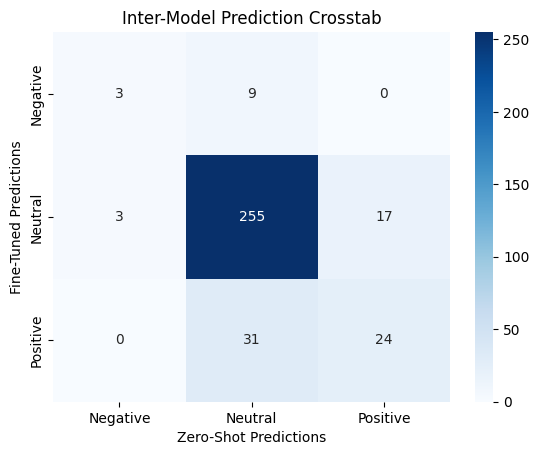

In [ ]:
# Confusion Matrix

crosstab = pd.crosstab(df_exploded["flan_t5_sentiment_tuned_label"],
                       df_exploded["flan_t5_sentiment_zero_shot"],
                       rownames=["Fine-Tuned"], colnames=["Zero-Shot"])

sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Zero-Shot Predictions")
plt.ylabel("Fine-Tuned Predictions")
plt.title("Inter-Model Prediction Crosstab")
plt.show()

* This shows that the Fine-Tuned model does seem able to discern positive / negative where Zero-shot could not - 31 and 9 sentences for Positive and Negative, respectively.
* There is strong agreement across the 'Neutral' category.

In [ ]:
df_exploded.head(2)

,Question_Sentence,Question,Asked By,Quarter-Year,flan_t5_sentiment_zero_shot,Sentence_t5_tuned_infer,flan_t5_sentiment_tuned,flan_t5_sentiment_tuned_label,flan_t5_sentiment_zero_shot_encoded
0,"So, Jamie, I was actually hoping to get your p...","So, Jamie, I was actually hoping to get your p...",Steven Chubak,1Q23,Neutral,"Classify sentiment: So, Jamie, I was actually ...",1,Neutral,1
0,In your letter you spent a fair amount of time...,"So, Jamie, I was actually hoping to get your p...",Steven Chubak,1Q23,Neutral,Classify sentiment: In your letter you spent a...,1,Neutral,1


In [ ]:
#Inter-model agreement
#label_to_num = {"Negative": 0, "Neutral": 1, "Positive": 2}

# Calculate Cohen's Kappa to quantify inter-model agreement

df_exploded["flan_t5_sentiment_tuned"] = df_exploded["flan_t5_sentiment_tuned"].astype(int)
df_exploded["flan_t5_sentiment_zero_shot_encoded"] = df_exploded["flan_t5_sentiment_zero_shot_encoded"].astype(int)

kappa = cohen_kappa_score(df_exploded["flan_t5_sentiment_tuned"],
                          df_exploded["flan_t5_sentiment_zero_shot_encoded"])
print(f"Cohen's Kappa: {kappa:.2f}")

# Filter out all non-matching rows

filtered_rows = df_exploded[
    df_exploded["flan_t5_sentiment_zero_shot"] != df_exploded["flan_t5_sentiment_tuned_label"]
]

print(f"Shape of filtered data: {filtered_rows.shape}")
print("Rows where Zero-Shot and Fine-Tuned predictions do not match:")
filtered_rows[["Question_Sentence", "flan_t5_sentiment_zero_shot", "flan_t5_sentiment_tuned_label"]].head(10)

Cohen's Kappa: 0.39
Shape of filtered data: (60, 9)
Rows where Zero-Shot and Fine-Tuned predictions do not match:


,Question_Sentence,flan_t5_sentiment_zero_shot,flan_t5_sentiment_tuned_label
2,You mentioned the Fed cuts coming sooner and p...,Neutral,Positive
3,My first question is you mentioned that your r...,Negative,Neutral
4,You've seen some inflows.,Positive,Neutral
5,You've got the GSIB buffer obviously going up ...,Neutral,Positive
7,You said capital markets activity has gone to ...,Neutral,Positive
18,"When you think about \nJeremy, I think you men...",Neutral,Positive
18,Or are you leaning towards concluding that may...,Neutral,Positive
19,To the extent that capital ratios do go up 20%...,Neutral,Positive
19,So how much business leaves JPMorgan or the in...,Neutral,Positive
21,"Meaning, a lot has changed on the institutiona...",Neutral,Positive


* Cohen's Kappa is 0.39. This indicates that there is only "fair agreement" between the fine-tuned model and the zero-shot model.
* This suggests that the models are often making different predictions, and the level of agreement beyond what you would expect by chance is relatively low.
* There are 60 rows for which the models disagree.
* To gain a better understanding of the rows which are disagreed upon, and as such which model we can give more confidence to, manual qualitative investigation is required.

In [ ]:
#Zero-shot = neutral, Tuned = positive

print(filtered_rows[
        (filtered_rows["flan_t5_sentiment_zero_shot"] == "Neutral") &
        (filtered_rows["flan_t5_sentiment_tuned_label"] == "Positive")
    ][["Question_Sentence", "flan_t5_sentiment_zero_shot", "flan_t5_sentiment_tuned_label"]].shape)

filtered_rows[
        (filtered_rows["flan_t5_sentiment_zero_shot"] == "Neutral") &
        (filtered_rows["flan_t5_sentiment_tuned_label"] == "Positive")
    ][["Question_Sentence", "flan_t5_sentiment_zero_shot", "flan_t5_sentiment_tuned_label"]]

(31, 3)


,Question_Sentence,flan_t5_sentiment_zero_shot,flan_t5_sentiment_tuned_label
2,You mentioned the Fed cuts coming sooner and p...,Neutral,Positive
5,You've got the GSIB buffer obviously going up ...,Neutral,Positive
7,You said capital markets activity has gone to ...,Neutral,Positive
18,"When you think about \nJeremy, I think you men...",Neutral,Positive
18,Or are you leaning towards concluding that may...,Neutral,Positive
19,To the extent that capital ratios do go up 20%...,Neutral,Positive
19,So how much business leaves JPMorgan or the in...,Neutral,Positive
21,"Meaning, a lot has changed on the institutiona...",Neutral,Positive
34,I understand the NII strategy benefited from F...,Neutral,Positive
41,Do you believe that the outlook for a soft lan...,Neutral,Positive


Insights from these (zero-shot = neutral, fine-tuned = positive) disagreement examples:
* The zero-shot model misses some of the nuances that the fine-tuned model correctly picks up as positive sentiment. For example: "You mentioned the Fed cuts coming sooner and positive feedback on the customer offers."

* We assume that the fine-tuned model is more adept at picking up domain-specific language, as it has been trained on the Financial Phrasebank. An example of this being the case: "You said capital markets activity has gone to bank lending, and I'm just wondering, as part of your $7 billion increased NII guide, are you assuming better loan spreads?" - the fine-tuned model seems to recognise that an "increased NII guide" and "better loan spreads" are positive signals in this context. Another example is "Or are you leaning towards concluding that maybe U.S. businesses, consumers have absorbed the rate cycle a lot better than we expected a year ago?".

* There are multiple cases where both models seem to be overestimating the sentiment. The example "So how much business leaves JPMorgan or the industry if capital ratios do go up as much as potentially proposed?" is arguably negative - business leaving a bank is not good, but neither model picked up on this. Interestingly, the fine-tuned model overestimated to a greater extent. Another example that demonstrates this: "And is this all because of the higher rate environment that's expected now?".

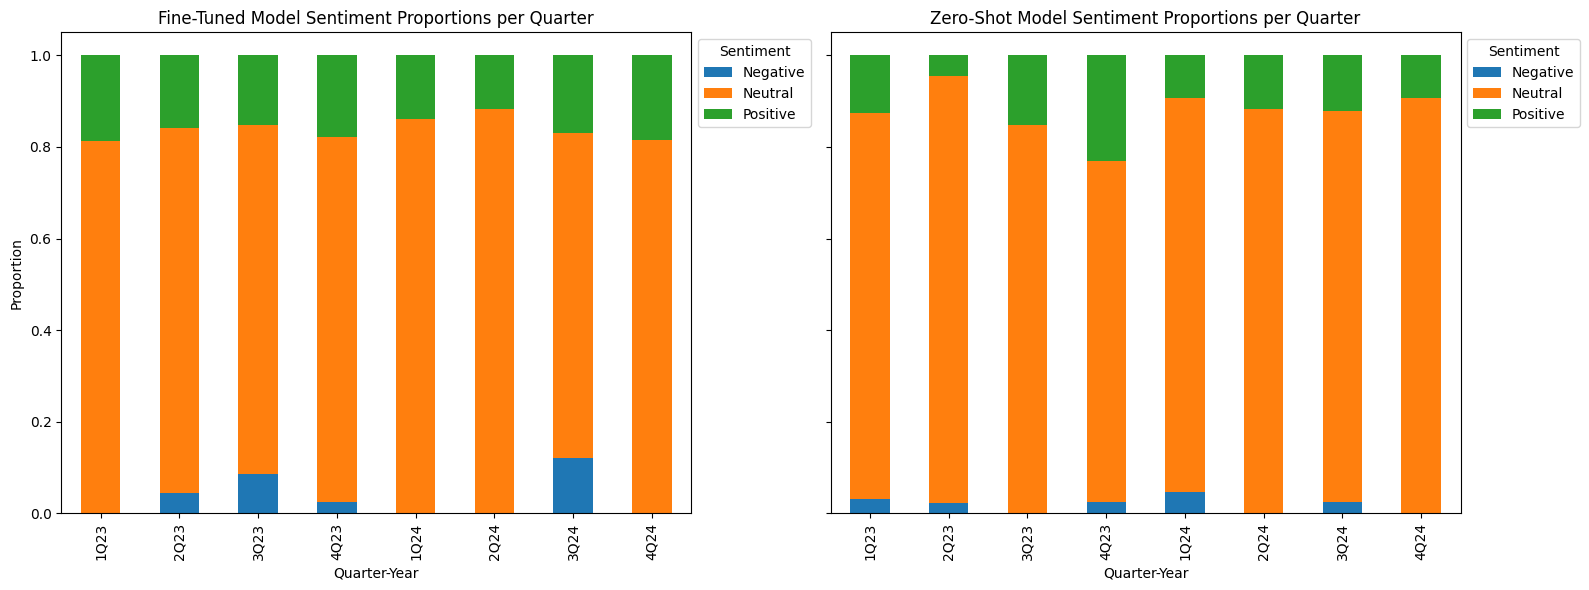

In [ ]:
#Bar plots of results over time

# Helper function to extract (year, quarter) from a quarter string like "1Q23"
def extract_year_quarter(q):
    m = re.match(r"(\d)Q(\d+)", q)
    if m:
        quarter = int(m.group(1))
        year = int(m.group(2))
        return (year, quarter)
    else:
        return (9999, 99)  # fallback if format doesn't match

# Group by quarter and sentiment for the fine-tuned model, count occurrences
tuned_counts = df_exploded.groupby(["Quarter-Year", "flan_t5_sentiment_tuned_label"]).size().unstack(fill_value=0)
zero_counts = df_exploded.groupby(["Quarter-Year", "flan_t5_sentiment_zero_shot"]).size().unstack(fill_value=0)

# Sort the quarters in chronological order using the helper function
sorted_quarters = sorted(tuned_counts.index, key=extract_year_quarter)
tuned_counts = tuned_counts.reindex(sorted_quarters)
zero_counts = zero_counts.reindex(sorted_quarters)

# Compute proportions per quarter
tuned_proportions = tuned_counts.div(tuned_counts.sum(axis=1), axis=0)
zero_proportions = zero_counts.div(zero_counts.sum(axis=1), axis=0)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Fine-Tuned Model Plot
tuned_proportions.plot(kind="bar", stacked=True, ax=axes[0])
axes[0].set_title("Fine-Tuned Model Sentiment Proportions per Quarter")
axes[0].set_xlabel("Quarter-Year")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Sentiment", bbox_to_anchor=(1.0, 1.0))

# Zero-Shot Model Plot
zero_proportions.plot(kind="bar", stacked=True, ax=axes[1])
axes[1].set_title("Zero-Shot Model Sentiment Proportions per Quarter")
axes[1].set_xlabel("Quarter-Year")
axes[1].legend(title="Sentiment", bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

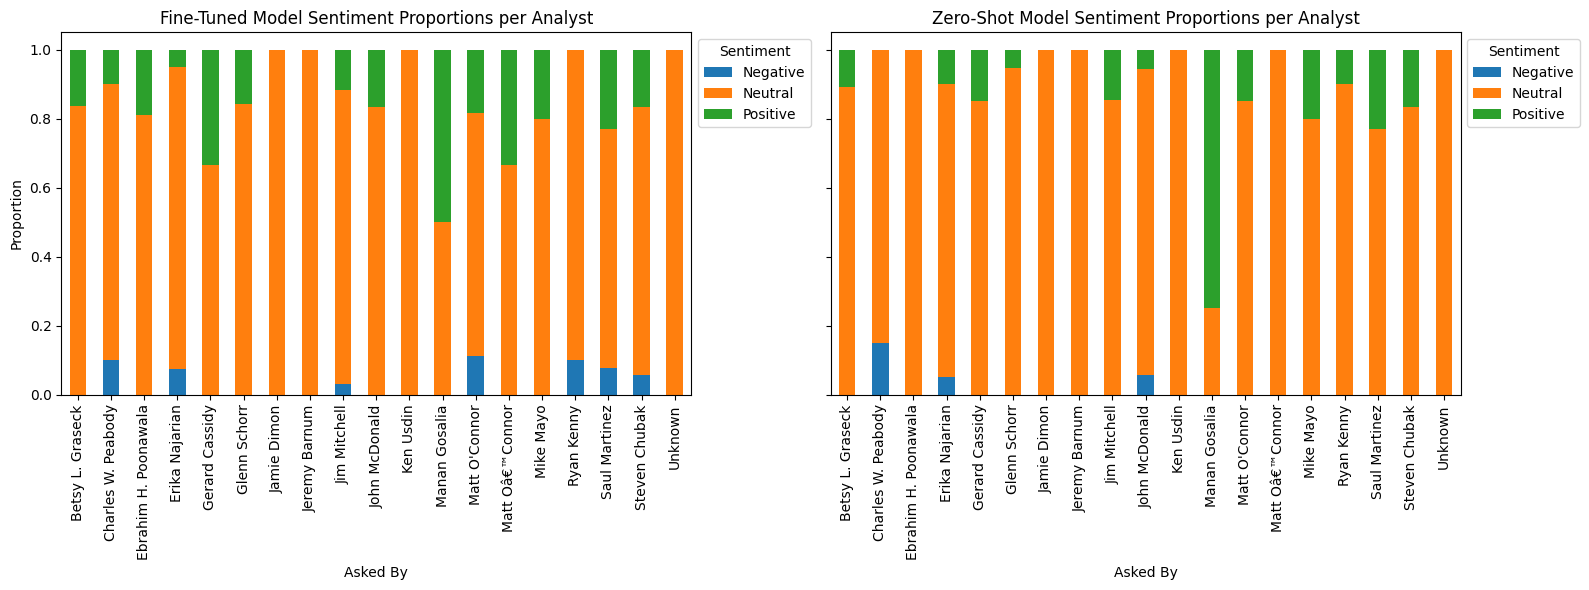

In [ ]:
#Bar plots of results per analyst

# Group by "Asked By" and sentiment for the fine-tuned model
analyst_counts_tuned = df_exploded.groupby(["Asked By", "flan_t5_sentiment_tuned_label"]).size().unstack(fill_value=0)
analyst_proportions_tuned = analyst_counts_tuned.div(analyst_counts_tuned.sum(axis=1), axis=0)

# Group by "Asked By" and sentiment for the zero-shot model
analyst_counts_zero = df_exploded.groupby(["Asked By", "flan_t5_sentiment_zero_shot"]).size().unstack(fill_value=0)
analyst_proportions_zero = analyst_counts_zero.div(analyst_counts_zero.sum(axis=1), axis=0)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Fine-Tuned Model Plot
analyst_proportions_tuned.plot(kind="bar", stacked=True, ax=axes[0])
axes[0].set_title("Fine-Tuned Model Sentiment Proportions per Analyst")
axes[0].set_xlabel("Asked By")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Sentiment", bbox_to_anchor=(1.0, 1.0))

# Zero-Shot Model Plot
analyst_proportions_zero.plot(kind="bar", stacked=True, ax=axes[1])
axes[1].set_title("Zero-Shot Model Sentiment Proportions per Analyst")
axes[1].set_xlabel("Asked By")
axes[1].legend(title="Sentiment", bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

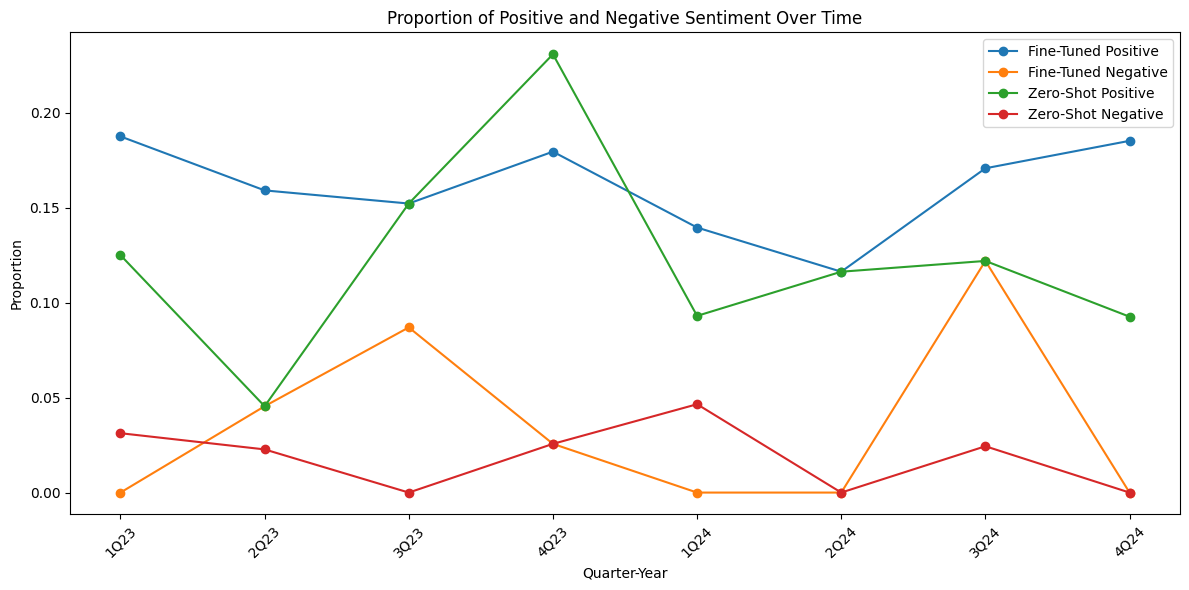

In [ ]:
# Line plot - pos/neg sentiment proportion trends over time

# Group by quarter and sentiment for fine-tuned model
tuned_counts = df_exploded.groupby(["Quarter-Year", "flan_t5_sentiment_tuned_label"]).size().unstack(fill_value=0)
# Ensure all three sentiment columns exist
for col in ["Negative", "Neutral", "Positive"]:
    if col not in tuned_counts.columns:
        tuned_counts[col] = 0
# Sort by quarter
sorted_quarters = sorted(tuned_counts.index, key=extract_year_quarter)
tuned_counts = tuned_counts.reindex(sorted_quarters)
tuned_proportions = tuned_counts.div(tuned_counts.sum(axis=1), axis=0)

# Group by quarter and sentiment for zero-shot model
zero_counts = df_exploded.groupby(["Quarter-Year", "flan_t5_sentiment_zero_shot"]).size().unstack(fill_value=0)
for col in ["Negative", "Neutral", "Positive"]:
    if col not in zero_counts.columns:
        zero_counts[col] = 0
zero_counts = zero_counts.reindex(sorted_quarters)
zero_proportions = zero_counts.div(zero_counts.sum(axis=1), axis=0)

# Prepare the x-axis labels (quarters)
quarters = tuned_proportions.index

# Plotting the lines
plt.figure(figsize=(12,6))

# Fine-Tuned model: Positive and Negative
plt.plot(quarters, tuned_proportions["Positive"], marker='o', label="Fine-Tuned Positive")
plt.plot(quarters, tuned_proportions["Negative"], marker='o', label="Fine-Tuned Negative")

# Zero-Shot model: Positive and Negative
plt.plot(quarters, zero_proportions["Positive"], marker='o', label="Zero-Shot Positive")
plt.plot(quarters, zero_proportions["Negative"], marker='o', label="Zero-Shot Negative")

plt.xlabel("Quarter-Year")
plt.ylabel("Proportion")
plt.title("Proportion of Positive and Negative Sentiment Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Insight:
* Zero-shot model seems to be labelling a lower overall proportion of questions as positive than the fine-tuned model, except for in 4Q23 where it labelled a higher proportion.
* Rows separated below.

In [ ]:
# Rows in 4Q23 where zero-shot predicted positive, AND fine-tuned did not predict positive

filtered_rows = df_exploded[
    (df_exploded["Quarter-Year"] == "4Q23") &
    (df_exploded["flan_t5_sentiment_zero_shot"] == "Positive") &
    (df_exploded["flan_t5_sentiment_tuned_label"] != "Positive")
]

print(f"Shape of filtered data: {filtered_rows.shape}")
filtered_rows[["Question_Sentence", "Quarter-Year", "flan_t5_sentiment_zero_shot", "flan_t5_sentiment_tuned_label"]]

Shape of filtered data: (5, 13)


,Question_Sentence,Quarter-Year,flan_t5_sentiment_zero_shot,flan_t5_sentiment_tuned_label
38,Thanks for all the comments on the net interes...,4Q23,Positive,Neutral
42,You printed 15% CET1 in the quarter.,4Q23,Positive,Neutral
42,"On a net basis, net of RWA growth, your net in...",4Q23,Positive,Neutral
43,And if you could just give some color on that.,4Q23,Positive,Neutral
45,Thanks for taking my questions.,4Q23,Positive,Neutral


* Interestingly 2 of these "You printed 15% CET1 in the quarter." and "On a net basis, net of RWA growth, your net income produces 51 basis points every quarter." do seem to be positive statements - the zero-shot model picked these up, whilst the fine-tuned model did not.
* Possible explanation: the fine-tuned model may be conservative in labeling such statements as positive, due to bias obtained from the training dataset, and the zero-shot model may be defaulting to a more generic interpretation - recognizing high numbers as inherently positive.
* This difference in learned context and sensitivity to numeric cues could be  leading to these differences in labelling.

# 4B) Manual verification (ground labelling)

* I will manually annotate the 2 most recent quarters 3Q24 and 4Q24 with sentiment labels.

In [ ]:
# Filter for rows from 3Q24 and 4Q24
df_manual = df_exploded[df_exploded["Quarter-Year"].isin(["3Q24", "4Q24"])]

# Save the filtered data to a CSV file
output_path = "/content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/manual_annotation_data.csv"
df_manual.to_csv(output_path, index=False)

print(f"Saved {df_manual.shape[0]} rows for manual annotation to '{output_path}'")

Saved 95 rows for manual annotation to '/content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/manual_annotation_data.csv'


The rules that will be followed when annotating the data:
* 1) Each sentence is assessed in isolation
* 2) Clear criteria for labelling - 'Positive' only if it contains clear indicators of optimism or improvement - 'Negative' if concerns or declines are highlighted - 'Neutral' if just facts are stated with no pos/neg tone (or irrelevant sentences e.g. 'Can you hear me okay?')

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/DS_CA/BOE/manual_annotation_data_labelled.csv"
ground_labelled = pd.read_csv(file_path)

ground_labelled = pd.DataFrame(ground_labelled)

ground_labelled = ground_labelled.reset_index(drop=True)
df_manual = df_manual.reset_index(drop=True)
df_manual["ground_label"] = ground_labelled["manual_sentiment"]

df_manual["flan_t5_sentiment_tuned_label"] = df_manual["flan_t5_sentiment_tuned_label"].astype(str)
df_manual["flan_t5_sentiment_zero_shot"] = df_manual["flan_t5_sentiment_zero_shot"].astype(str)
df_manual["ground_label"] = df_manual["ground_label"].astype(str)

In [ ]:
df_manual["ground_label"].value_counts()

,count
ground_label,
Neutral,68
Negative,17
Positive,10


Fine-Tuned Model Metrics:
Accuracy: 0.7473684210526316
Weighted F1: 0.7373058694447272
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.29      0.45        17
     Neutral       0.82      0.88      0.85        68
    Positive       0.35      0.60      0.44        10

    accuracy                           0.75        95
   macro avg       0.72      0.59      0.58        95
weighted avg       0.80      0.75      0.74        95


Zero-Shot Model Metrics:
Accuracy: 0.7578947368421053
Weighted F1: 0.6952293013234842
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.06      0.11        17
     Neutral       0.77      0.96      0.86        68
    Positive       0.60      0.60      0.60        10

    accuracy                           0.76        95
   macro avg       0.79      0.54      0.52        95
weighted avg       0.80      0.76      0.70        95



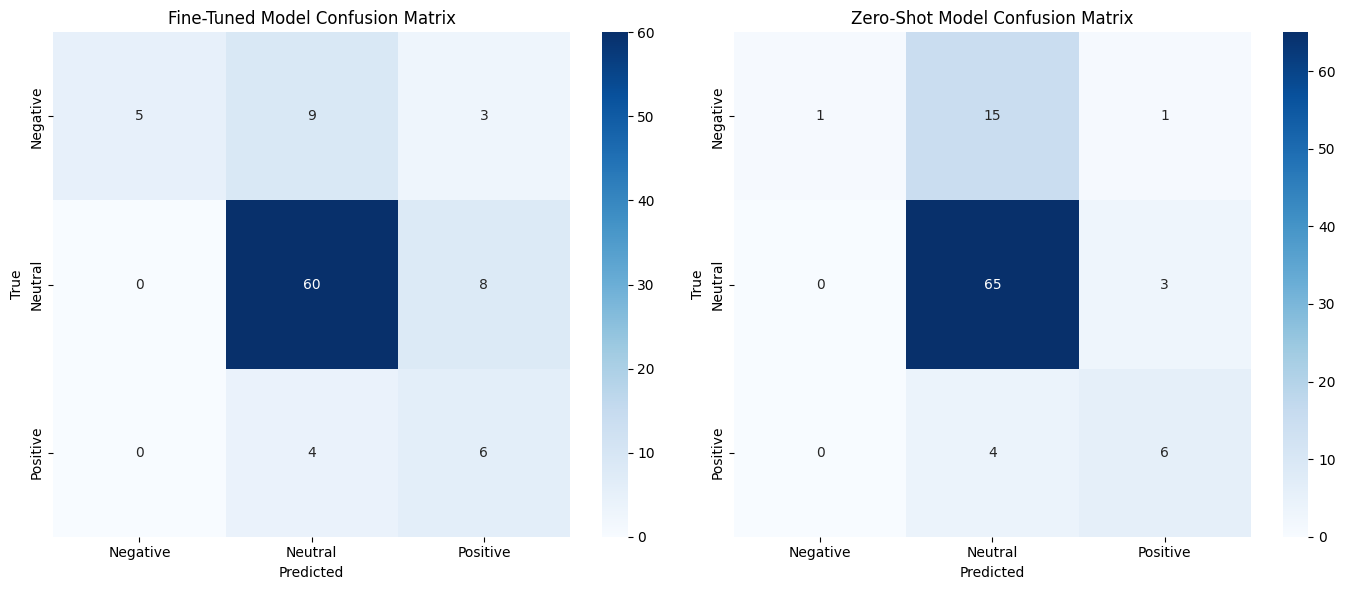

In [ ]:
# Define the target names in the order you expect them
target_names = ["Negative", "Neutral", "Positive"]

# ----------------------------
# Metrics for Fine-Tuned Model
# ----------------------------
accuracy_tuned = accuracy_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"])
f1_tuned = f1_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"], average="weighted")
report_tuned = classification_report(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"], target_names=target_names)

print("Fine-Tuned Model Metrics:")
print("Accuracy:", accuracy_tuned)
print("Weighted F1:", f1_tuned)
print("Classification Report:\n", report_tuned)

# ----------------------------
# Metrics for Zero-Shot Model
# ----------------------------
accuracy_zero = accuracy_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"])
f1_zero = f1_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"], average="weighted")
report_zero = classification_report(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"], target_names=target_names)

print("\nZero-Shot Model Metrics:")
print("Accuracy:", accuracy_zero)
print("Weighted F1:", f1_zero)
print("Classification Report:\n", report_zero)

# ----------------------------
# Confusion Matrix Plotting
# ----------------------------
cm_tuned = confusion_matrix(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"], labels=target_names)
cm_zero = confusion_matrix(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"], labels=target_names)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix for Fine-Tuned Model
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_title("Fine-Tuned Model Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Confusion Matrix for Zero-Shot Model
sns.heatmap(cm_zero, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_title("Zero-Shot Model Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


Very promising results when comparing the results for 3Q24 and 4Q24 to manually added ground labels:
* Although overall accuracy was higher for the zero-shot model (0.76 vs 0.75), the fine-tuned model has a significantly higher weighted F1 score (0.74 vs 0.70). This indicates that, with consideration of the proportions of each class, the fine-tuned model balances performance across the classes better.
* The fine-tuned model's negative recall eclipsed the zero-shot model (0.29 vs 0.06). The fine-tuned model predicts a larger proportion of the ground-labelled 'Negative's - this is important given our context - we hypothesised that negative sentiment could help us to signal financial distress.

Two key caveats:
* 1) Only 2 quarters worth of data was ground-labelled.
* 2) The data was annotated by only one non-field expert.

Next steps:
* Analyse sentiment of answer and management discussion data, using the fine-tuned model.